# Perceptron à *N* couches

In [49]:
import numpy as np
import scipy.special

try:
    import cupy as cp
    import cupyx.scipy.special
except:
    cp = None
    cupyx = None


class NeuralNetMLP(object):
    """Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_output : int
        Number of output units, should be equal to the number of unique class labels.
    n_features : int
        Number of features (dimensions) in the target dataset.Should be equal to the number of columns in the X array.
    n_hidden : list (default: [30])
        List containing the number of hidden units in each hidden layer. By default, a
        single hidden layer containing 30 units is used.
    l1 : float (default: 0.0)
        Lambda value for L1-regularization. No regularization if l1=0.0 (default)
    l2 : float (default: 0.0)
        Lambda value for L2-regularization. No regularization if l2=0.0 (default)
    epochs : int (default: 500)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    alpha : float (default: 0.0)
        Momentum constant. Factor multiplied with the gradient of the previous epoch t-1 to improve learning speed
        w(t) := w(t) - (grad(t) + alpha*grad(t-1))
    decrease_const : float (default: 0.0)
        Decrease constant. Shrinks the learning rate after each epoch via eta / (1 + epoch*decrease_const)
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatches : int (default: 1)
        Divides training data into k minibatches for efficiency. Normal gradient descent learning if k=1 (default).
    random_state : int (default: None)
        Set random state for shuffling and initializing the weights.
    device : {'cpu', 'cuda'} (default: 'cpu')
        The device onto which the model is fitted. Cupy must be installed to fit the
        model on the 'gpu'.

    Attributes
    -----------
    cost_ : list
      Sum of squared errors after each epoch.

    """

    def __init__(
        self,
        n_output,
        n_features,
        n_hidden=[30],
        l1=0.0,
        l2=0.0,
        epochs=500,
        eta=0.001,
        alpha=0.0,
        decrease_const=0.0,
        shuffle=True,
        minibatches=1,
        random_state=None,
        device="cpu",
    ):

        if device == "cuda" and cp is None:
            raise RuntimeError(
                "Cupy is not installed. The only available device is 'cpu'."
            )

        self.device = device

        xp = cp if self.device == "cuda" else np
        xp.random.seed(random_state)

        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.weights, self.biases = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

    def _encode_labels(self, y, k):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]   Target values.

        Returns
        -----------
        onehot : array, shape = (n_labels, n_samples)

        """
        xp = cp if self.device == "cuda" else np

        onehot = xp.zeros((k, y.shape[0]))
        onehot[y, np.arange(y.shape[0])] = 1

        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        xp = cp if self.device == "cuda" else np

        weights = []
        biases = []

        # Weights of the hidden layers and output layers
        prev = self.n_features

        for layer in self.n_hidden + [self.n_output]:
            w = xp.random.uniform(-1.0, 1.0, size=(layer, prev))
            b = xp.random.uniform(-1.0, 1.0, size=layer)

            prev = layer

            weights.append(w)
            biases.append(b)

        return weights, biases

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)

        Uses scipy.special.expit to avoid overflow
        error for very small input values z.

        """
        if self.device == "cuda":
            return cupyx.scipy.special.expit(z)
        else:
            return scipy.special.expit(z)

    def _sigmoid_gradient(self, z):
        """Compute gradient of the logistic function"""
        sg = self._sigmoid(z)
        return sg * (1.0 - sg)

    def _feedforward(self, X, weights, biases):
        """Compute feedforward step

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        weights : list
            List of 2D arrays containing the weights of the model layers.
        biases : list
            List of 1D arrays containing the bias weights of the model layers.

        Returns
        ----------
        forward : list[Tuple]
            List containing for each layer (including input and output layers) a 2-elements
            tuple of the net input *z* and the activated array *a*. For the input layer,
            the tuple (X.T, X.T) is returned.

        """
        # Memory of previous operations: list of tuples (z,a)
        forward = []

        # Transpose X (first layer)
        a = X.T
        forward.append((a, a))  # No 'z' for input layer

        # Apply layers
        for w, b in zip(weights, biases):
            # Net input: z^(i)
            z = w.dot(a) + b[:, None]

            # Activation: a^(i)
            a = self._sigmoid(z)

            # Append to memory
            forward.append((z, a))

        return forward

    def _L2_reg(self, lambda_, weights):
        """Compute L2-regularization cost"""
        xp = cp if self.device == "cuda" else np
        return (lambda_ / 2.0) * sum(xp.sum(w**2) for w in weights)

    def _L1_reg(self, lambda_, weights):
        """Compute L1-regularization cost"""
        xp = cp if self.device == "cuda" else np
        return (lambda_ / 2.0) * sum(xp.abs(w).sum() for w in weights)

    def _get_cost(self, y_enc, output, weights):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        output : array, shape = [n_output_units, n_samples]
            Activation of the output layer (feedforward)
        weights : list
            List of 2D arrays containing the weights of the model layers.
        biases : list
            List of 1D arrays containing the bias weights of the model layers.

        Returns
        ---------
        cost : float
            Regularized cost.

        """
        xp = cp if self.device == "cuda" else np

        term1 = -y_enc * (xp.log(output))
        term2 = (1.0 - y_enc) * xp.log(1.0 - output)
        cost = xp.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, weights)
        L2_term = self._L2_reg(self.l2, weights)
        cost = cost + L1_term + L2_term
        return cost

    #
    # Nous verrons plus tard
    #
    def _get_gradient(self, forward, y_enc, weights):
        """Compute gradient step using backpropagation.

        Parameters
        ------------
        forward : list[Tuple]
            List containing for each layer (including input and output layers) a 2-elements
            tuple of the net input *z* and the activated array *a*. For the input layer,
            the tuple (X.T, X.T) is expected.
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        weights : list
            List of 2D arrays containing the weights of the model layers.

        Returns
        ---------
        grad_w : list
            List of gradients for all weight arrays
        grad_b : list
            List of biases for all weight bias arrays

        """
        xp = cp if self.device == "cuda" else np

        grad_w = []
        grad_b = []

        # Erreur de classification
        sigma = forward[-1][1] - y_enc

        for i, ((z, a), w) in enumerate(zip(reversed(forward[:-1]), reversed(weights))):
            # Compute gradient: sigma^(i+1) * [a^(i)]^T
            gw = sigma.dot(a.T)
            gb = sigma.sum(axis=1)

            # Regularize (not biases)
            gw += self.l2 * w
            gw += self.l1 * xp.sign(w)

            # Append gradients
            grad_w.append(gw)
            grad_b.append(gb)

            # Update error to previous layer (do not update if first layer)
            if i < len(weights) - 1:
                sigma = w.T.dot(sigma) * self._sigmoid_gradient(z)

        # Reverse gradients
        grad_w = [gw for gw in reversed(grad_w)]
        grad_b = [gb for gb in reversed(grad_b)]

        return grad_w, grad_b

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        xp = cp if self.device == "cuda" else np

        if len(X.shape) != 2:
            raise AttributeError(
                "X must be a [n_samples, n_features] array.\n"
                "Use X[:,None] for 1-feature classification,"
                "\nor X[[i]] for 1-sample classification"
            )

        forward = self._feedforward(xp.asarray(X), self.weights, self.biases)
        y_pred = xp.argmax(forward[-1][1], axis=0)
        return y_pred

    #
    # Fonction d'entraînement
    #
    def fit(self, X, y, print_progress=False):
        """Learn weights from training data.

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        y : array, shape = [n_samples]
            Target class labels.
        print_progress : bool (default: False)
            Prints progress as the number of epochs
            to stderr.

        Returns:
        ----------
        self

        """
        xp = cp if self.device == "cuda" else np

        self.cost_ = xp.zeros((self.epochs, self.minibatches))

        X_data = xp.asarray(X.copy())
        y_data = xp.asarray(y.copy())

        y_enc = self._encode_labels(y, self.n_output)  # Vecteur one-hot

        delta_w_prev = [xp.zeros(w.shape) for w in self.weights]
        delta_b_prev = [xp.zeros(b.shape) for b in self.biases]

        for i in range(self.epochs):  # Nombre de passage sur le dataset
            # adaptive learning rate
            self.eta /= (
                1 + self.decrease_const * i
            )  # Permet de réduire le nombre d'epochs nécessaire à la convergence en limitant les risques de "pas" trop grand!

            if print_progress:
                print(f"Epoch: {i+1}/{self.epochs}", end="\r")

            if self.shuffle:  # on mélange le dataset à chaque epoch
                idx = xp.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]

            mini = xp.array_split(
                xp.arange(y_data.shape[0]), self.minibatches
            )  # Si le mode minibatch est activé, le dataset en entrée est divisé en batch pour le calcul des gradients

            for j, idx in enumerate(mini):
                # feedforward
                forward = self._feedforward(X_data[idx], self.weights, self.biases)
                cost = self._get_cost(
                    y_enc=y_enc[:, idx], output=forward[-1][1], weights=self.weights
                )
                self.cost_[i, j] = cost

                # compute gradients via backpropagation
                grad_w, grad_b = self._get_gradient(
                    forward, y_enc[:, idx], self.weights
                )

                # Compute delta_w, delta_b
                delta_w = [self.eta * gw for gw in grad_w]
                delta_b = [self.eta * gb for gb in grad_b]

                # Update weights and biases
                for k, (dw, db) in enumerate(zip(delta_w, delta_b)):
                    self.weights[k] -= dw + self.alpha * delta_w_prev[k]
                    self.biases[k] -= db + self.alpha * delta_b_prev[k]

                # Keep previous weights and biases for momentum
                delta_w_prev = delta_w
                delta_b_prev = delta_b

        return self

In [50]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt


def load_mnist(path, kind="train"):
    labels_path = os.path.join(path, "%s-labels-idx1-ubyte" % kind)
    images_path = os.path.join(path, "%s-images-idx3-ubyte" % kind)

    with open(labels_path, "rb") as lbpath:
        magic, n = struct.unpack(">II", lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, "rb") as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels


X_train, y_train = load_mnist("perceptron_multicouches/data/MNIST/raw/", kind="train")
X_test, y_test = load_mnist("perceptron_multicouches/data/MNIST/raw/", kind="t10k")
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(60000, 784), dtype=uint8)

In [51]:
nn = NeuralNetMLP(
    n_output=10,
    n_features=X_train.shape[1],
    n_hidden=[256, 128, 64, 32],
    l2=0.1,
    l1=0.0,
    epochs=1000,
    eta=0.001,
    alpha=0.001,
    decrease_const=0.00001,
    minibatches=50,
    shuffle=True,
    random_state=1,
    device="cuda",
)

In [52]:
nn.fit(X_train, y_train, print_progress=True)

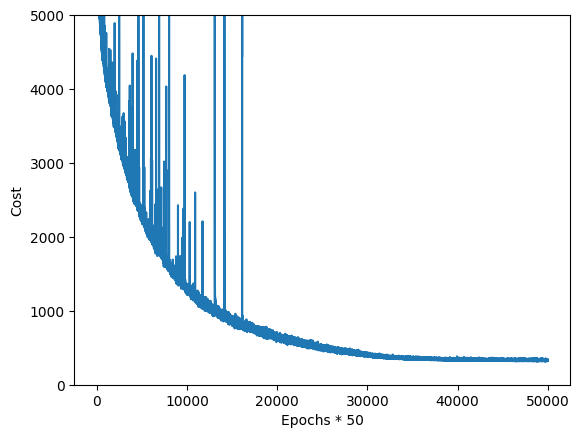

In [59]:
fig, ax = plt.subplots()

ax.plot(nn.cost_.flatten().get())
ax.set_ylim([0, 5000])
ax.set_ylabel("Cost")
ax.set_xlabel("Epochs * 50")
fig.savefig("./figures/cost.png", dpi=300, bbox_inches="tight")

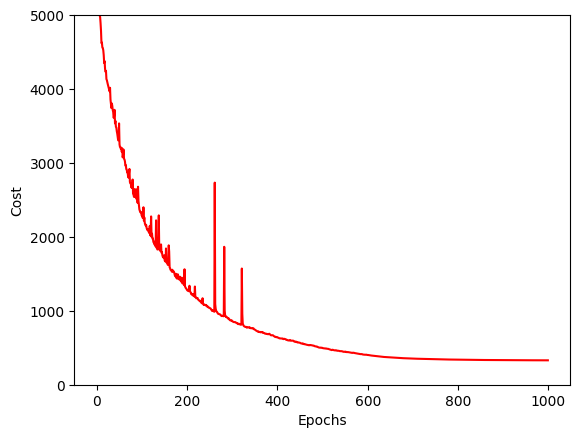

In [61]:
fig, ax = plt.subplots()
ax.plot(nn.cost_.mean(axis=1).get(), color="red")
ax.set_ylim([0, 5000])
ax.set_ylabel("Cost")
ax.set_xlabel("Epochs")
fig.savefig("./figures/cost2.png", dpi=300, bbox_inches="tight")

In [62]:
y_train_pred = nn.predict(X_train).get()
acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]
print("Training accuracy: %.2f%%" % (acc * 100))

y_test_pred = nn.predict(X_test).get()
acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]
print("Test accuracy: %.2f%%" % (acc * 100))

Training accuracy: 99.83%
Test accuracy: 97.62%


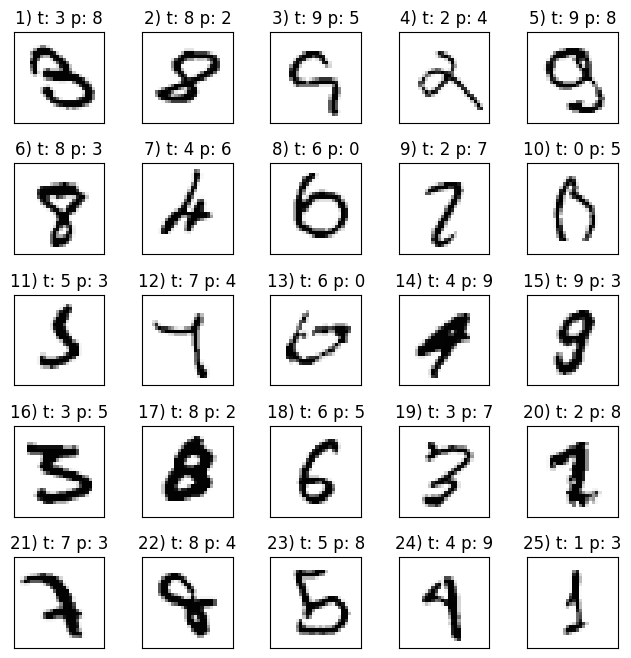

In [63]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, axes = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(8, 8))
fig.subplots_adjust(hspace=0.45)
axes = axes.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    axes[i].imshow(img, cmap="Greys", interpolation="nearest")
    axes[i].set_title("%d) t: %d p: %d" % (i + 1, correct_lab[i], miscl_lab[i]))

axes[0].set_xticks([])
axes[0].set_yticks([])

fig.savefig("./figures/mnist_miscl.png", dpi=300, bbox_inches="tight")

# Utilisation du modèle avec Fashion MNIST

In [64]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt


X_train, y_train = load_mnist("fashion_mnist/", kind="train")
X_test, y_test = load_mnist("fashion_mnist/", kind="t10k")
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(60000, 784), dtype=uint8)

In [65]:
fmnist_labels = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

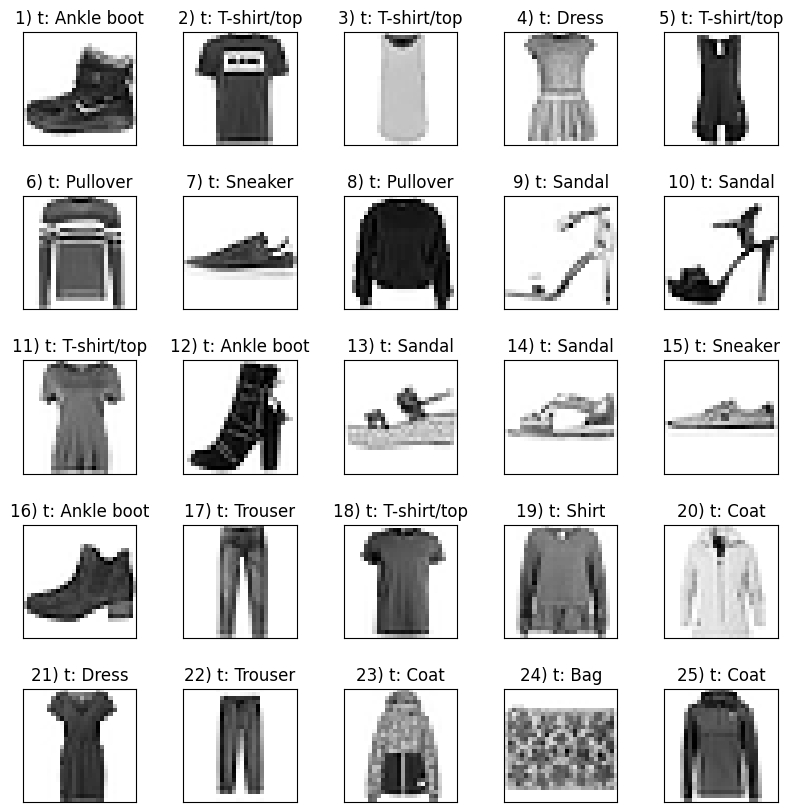

In [66]:
miscl_img = X_train[:25]
correct_lab = y_train[:25]

fig, axes = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(10, 10))
fig.subplots_adjust(hspace=0.45)
axes = axes.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    axes[i].imshow(img, cmap="Greys", interpolation="nearest")
    axes[i].set_title(f"{i+1}) t: {fmnist_labels[correct_lab[i]]}")

axes[0].set_xticks([])
axes[0].set_yticks([])

fig.savefig("./figures/fashion_mnist_miscl.png", dpi=300, bbox_inches="tight")

In [68]:
nn2 = NeuralNetMLP(
    n_output=10,
    n_features=X_train.shape[1],
    n_hidden=[256, 128, 32],
    l2=0.1,
    l1=0.0,
    epochs=1000,
    eta=0.001,
    alpha=0.001,
    decrease_const=0.00001,
    minibatches=50,
    shuffle=True,
    random_state=1,
    device="cuda",
)

In [69]:
nn2.fit(X_train, y_train, print_progress=True)

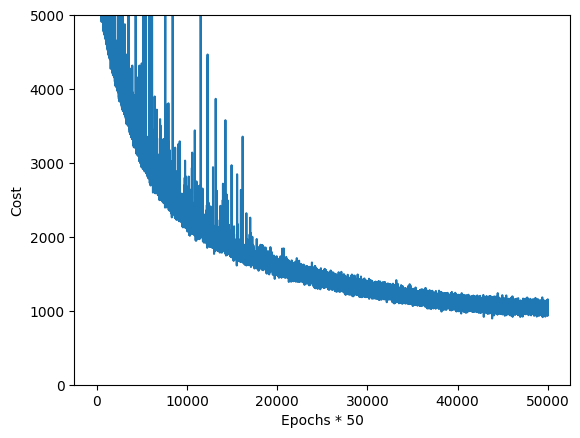

In [70]:
fig, ax = plt.subplots()

ax.plot(nn2.cost_.flatten().get())
ax.set_ylim([0, 5000])
ax.set_ylabel("Cost")
ax.set_xlabel("Epochs * 50")
fig.savefig("./figures/fashion_mnist_cost.png", dpi=300, bbox_inches="tight")

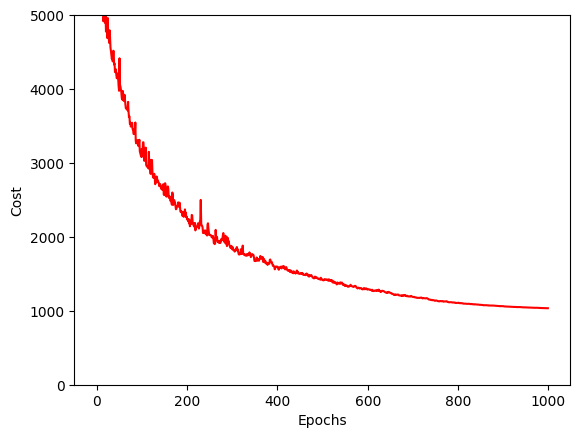

In [71]:
fig, ax = plt.subplots()
ax.plot(nn2.cost_.mean(axis=1).get(), color="red")
ax.set_ylim([0, 5000])
ax.set_ylabel("Cost")
ax.set_xlabel("Epochs")
fig.savefig("./figures/fashion_mnist_cost2.png", dpi=300, bbox_inches="tight")

In [72]:
y_train_pred = nn2.predict(X_train).get()
acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]
print("Training accuracy: %.2f%%" % (acc * 100))

y_test_pred = nn2.predict(X_test).get()
acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]
print("Test accuracy: %.2f%%" % (acc * 100))

Training accuracy: 87.99%
Test accuracy: 85.35%


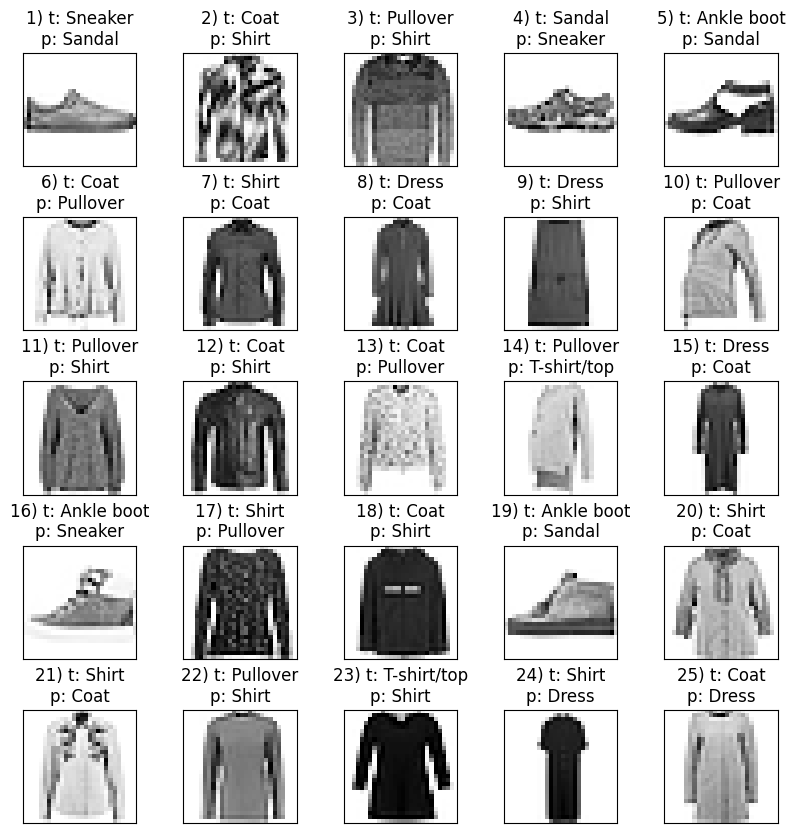

In [73]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, axes = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(10, 10))
fig.subplots_adjust(hspace=0.45)
axes = axes.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    axes[i].imshow(img, cmap="Greys", interpolation="nearest")
    axes[i].set_title(f"{i+1}) t: {fmnist_labels[correct_lab[i]]}\np: {fmnist_labels[miscl_lab[i]]}")

axes[0].set_xticks([])
axes[0].set_yticks([])

fig.savefig("./figures/fashion_mnist_miscl.png", dpi=300, bbox_inches="tight")